In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
from scipy.ndimage import gaussian_filter1d
from math import floor
import leidenalg as la
import igraph as ig
import csv
from read_roi import read_roi_file, read_roi_zip
from elephant.spike_train_generation import homogeneous_poisson_process
import elephant.conversion as conv
import neo as n
import quantities as pq
from quantities import Hz, s, ms

In [2]:
class temporal_network:#object for creating node-aligned(every node exists every layer)
                       #with diagonal coupling(inter-layer edges exist only between node to itself)
        
    ##################################
    # TODO: extend omega(scalar) for vector and matrix
    ##################################
        
    def __init__(self, size, length, data, **kwargs):
        
        if length < 1: raise ValueError('Object should be a multilayer network with at least 2 layers')
        if size < 3: raise ValueError('Layers must have at least 3 nodes')
        
        self.size = size # number of nodes in every layer
        self.length = length # number of layers
        self.nodes = [i for i in range(self.size)]
        
        #### data: supra__adjacency, list_adjacency, edge_list
        
        ##         if supra__adjacency: creates the list adjacency matrix
        ##
        ##                     --- additional arguments ---
        ##                       - supra_adjacency: supra adjacency matrix of shape (size*time x size*time)
        
        
        ##
        ##         if edge__list: creates directed weighted multilayer network from the egde quadraplets
        ##                      given of the form (i,j,w,t). supra_adjacency and list_adjacency matrices 
        ##                      are automatically created. Caveat: if you use edge_list only firing neurons are going
        ##                      to be taken ito consideration.
        ##
        ##                     --- additional arguments ---
        ##                       - edge_list: list of quadreplets e.g. [(0,2,w1,1),(2,1,w2,1),(0,1,w3,2),(0,2,w4,2)]
        ##                       - omega: interlayer coupling strength, can be a float only for now
        ##                       - kind: if ordinal, only adjacent layers gets connected with strength scalar 'omega'
        ##                               if cardinal, all layers get connected w/ each other w/ strength scalar 'omega'
        
        
        ##         if list__adjacency: creates the supra adjacency matrix from given list of adjacency matrices
        ##                             of monolayer networks
        ##                             TODO:add a warning to check if the adjacency matrices are node-aligned
        ##                      
        ##              
        ##                     --- additional arguments ---
        ##                       - list_adjacency: list of length 'length' that contains individual adjacency
        ##                                         matrices of each layer that are numpy arrays
        ##                       - omega: interlayer coupling strength, can be a float only for now
        ##                       - kind : if ordinal, only adjacent layers gets connected w/ strength scalar'omega'
        ##                                if cardinal, all layers get connected w/ each other w/ strength scalar'omega'
        ##
        ####
                    
        if  data == 'supra__adjacency':
            self.supra_adjacency = kwargs['supra_adjacency']
            list_adjacency = [ [] for i in range(length) ]
            
            for i in range(self.length):
                list_adjacency[i] = self.supra_adjacency[i*self.size:(i+1)*self.size,i*self.size:(i+1)*self.size]
            
            self.list_adjacency = list_adjacency
            
            edge_list = []
            for i in range(self.length):
                A = self.list_adjacency[i]
                firing = np.transpose(np.nonzero(A))
                for j,m in enumerate(firing):
                    quadreplet =(m[0],m[1],A[m[0],m[1]],i)
                    edge_list.append(quadreplet)
            self.edgelist = edge_list
                
        
        elif data == 'edge__list':
            self.edgelist = kwargs['edge_list']
            supra_adjacency = np.zeros((self.size*self.length,self.size*self.length))
            list_adjacency = [ [] for i in range(self.length) ]
            for q in range(self.length):
                list_adjacency[q]=np.zeros((self.size,self.size))
            
            for k,e in enumerate(self.edgelist):
                i,j,w,t = e[0], e[1], e[2],e[3]
                supra_adjacency[self.size*(t)+i][self.size*(t)+j] = w
                list_adjacency[t][i][j] = w

        
            ##filling off-diagonal blocks
            if kwargs['kind'] == 'ordinal':
                for n in range(self.size*(self.length-1)):
                    supra_adjacency[n][n+self.size] = kwargs['omega']
                    supra_adjacency[n+self.size][n] = kwargs['omega']
                
            elif kwargs['kind'] == 'cardinal':
                i = 0
                while self.length-i != 0:
                    i = i+1
                    for n in range(self.size*(self.length-i)):
                        supra_adjacency[n][n+i*self.size] = kwargs['omega']
                        supra_adjacency[n+i*self.size][n] = kwargs['omega']
            
            self.supra_adjacency = supra_adjacency
            self.list_adjacency = list_adjacency
            
        elif data == 'list__adjacency':
            self.list_adjacency = kwargs['list_adjacency']
            supra_adjacency = np.zeros((self.size*self.length,self.size*self.length))
            
            for i in range(self.length):
                supra_adjacency[i*self.size:(i+1)*self.size,i*self.size:(i+1)*self.size] = self.list_adjacency[i]
            
            ##filling off-diagonal blocks
            if kwargs['kind'] == 'ordinal':
                for n in range(self.size*(self.length-1)):
                    supra_adjacency[n][n+self.size] = kwargs['omega']
                    supra_adjacency[n+self.size][n] = kwargs['omega']
                
            elif kwargs['kind'] == 'cardinal':
                i = 0
                while self.length-i != 0:
                    i = i+1
                    for n in range(self.size*(self.length-i)):
                        supra_adjacency[n][n+i*self.size] = kwargs['omega']
                        supra_adjacency[n+i*self.size][n] = kwargs['omega']
            
            self.supra_adjacency = supra_adjacency
            
            edge_list = []
            for i in range(self.length):
                A = self.list_adjacency[i]
                firing = np.transpose(np.nonzero(A))
                for j,m in enumerate(firing):
                    quadreplet =(m[0],m[1],A[m[0],m[1]],i)
                    edge_list.append(quadreplet)
            self.edgelist = edge_list
            
    def aggragate(self, normalized = True):
        t = self.length
        n = self.size
        aggragated = np.zeros((n,n))
        
        for i,c in enumerate(self.list_adjacency):
            aggragated = aggragated + c
            
        if normalized: return (aggragated/t)
        else: return (aggragated)
            
    def modularity_matrix(self, omega, gamma):##TODO: fix modularity matrix
        N = self.size
        T = self.length
        B = np.zeros((N*T,N*T))
        two_mu = 0
        for i in range(T):
            k = np.sum(self.multi_array[i],0)
            two_m = np.sum(k,0)
            two_mu = two_mu + two_m
            B[i*N:(i+1)*N,i*N:(i+1)*N] = self.multi_array[i] - (gamma * k.T*k)/(two_m)
        two_mu = two_mu + 2*omega*N*(T-1)
        
        for p in range(N*(T-1)):
            B[p][p+N] = omega 
            B[p+N][p] = omega
            
        return(B)
    
    def binarize(self, array):
        n,t = array.shape
        binary_spikes = np.zeros((n,t))
        for i in range(n):
            for j in range(t):
                if array[i][j] == 0: pass
                else: binary_spikes[i][j] = 1
        return(binary_spikes)
    
    def bin_time_series(self, array, binsize, gaussian = True, **kwargs):
        #input: nxt matrix 
        #returns: binned time series i.e. l x n x binsize
    
        n = array.shape[0] # number of neurons
        totalsize = array.shape[1] # total duration of spikes
        l = int(totalsize/binsize) # number of resulting layers
        if gaussian:
            for i in range(n):
                array[i] = gaussian_filter(array[i],kwargs['sigma'])
    
        A = np.zeros((l,n,binsize))
        for i in range(l):
            A[i] = array[:,i*binsize:(i+1)*binsize]
        return(A)
    
    def edgelist2edges(self):
        T = self.length
        all_edges = [[] for i in range(T)]
        all_weights = [[] for i in range(T)]
        dtype = [('row',int),('column',int),('weight',float),('layer',int)]
        for k,e in enumerate(np.sort(np.array(self.edgelist, dtype=dtype),order='layer')):
            i,j,w,t = e[0], e[1], e[2],e[3]
            pair = (i,j)
            all_edges[t].append(pair)
            all_weights[t].append(w)
        return (all_edges, all_weights)
    
    def neighbors(self,node_id, layer):
        
        if node_id > self.size: return('Invalid node ID')
        if layer > self.length: return('Invalid layer')
        neighbors = []
        
        for k,e in enumerate(self.edgelist):
            i,j,w,t = e[0],e[1],e[2],e[3]
            if t != layer:pass
            else:
                if i != node_id:pass
                else:neighbors.append(j)
                    
        return(neighbors)
    
    def average_degree(self,layer):
        
        average_degree = 0
        
        for i in range(self.size):
            average_degree = average_degree + len(self.neighbors(i,layer))
        
        return(average_degree/(2*self.size))
    
    def create_igraph(self):
        T = self.length
        N = self.size
        G = []
        edges = self.edgelist2edges()[0]
        weights = self.edgelist2edges()[1]
        for i in range(T):
            G.append(ig.Graph())
            G[i].add_vertices(N)
            G[i].add_edges(edges[i])
            G[i].es['weight'] = weights[i]
            G[i].vs['id'] = list(range(N))
            G[i].vs['node_size'] = 0
        return(G)
    
    def leiden(self, G, interslice, resolution):
        
        layers, interslice_layer, G_full = la.time_slices_to_layers(G, interslice_weight = interslice)
        
        layer_partitions = [la.RBConfigurationVertexPartition(H, 
                                                              weights = 'weight', 
                                                              resolution_parameter = resolution) for H in layers]
        
        interslice_partition = la.RBConfigurationVertexPartition(interslice_layer, 
                                                                 weights = 'weight',
                                                                resolution_parameter = 0)
                                                     
        optimiser = la.Optimiser()
        
        diff = optimiser.optimise_partition_multiplex(layer_partitions + [interslice_partition],
                                                      n_iterations = -1)
        
        return(layer_partitions, interslice_partition)
    
    def membership(self,interslice_partition): ## returns the community assignments from the leiden algorithm as
        ##                                       tuple (n,t) n is the node id t is the layer that node is in
        n = self.size
        membership = [[] for i in range(interslice_partition._len)]
        for i,m in enumerate(interslice_partition._membership):
            time = floor(i/n)
            node_id = i%n
            membership[m].append((node_id,time))
        return(membership,interslice_partition._len)
    
    def community(self, membership, ax, m_type=None, subject=None):
        n = self.size
        t = self.length
        number_of_colors = len(membership)
        
        #pv = read_pv(m_type, subject)

        comms = np.zeros((n,t))

        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]

        for i, l in enumerate(membership):
            for j,k in enumerate(l):
                comms[k[0]][k[1]] = i+1

        cmap = mpl.colors.ListedColormap(color)

        #fig,ax = plt.subplots(1,1,figsize=(7,5))
        ax.imshow(comms, interpolation = 'none', cmap = cmap, aspect = 'auto', origin = 'lower')
        ax.set_xticks(np.arange(t))
        #ax.set_yticks(pv)
        ax.tick_params(axis = 'both', labelsize = 13)
        ax.set_xlabel('Layers (Time)', fontsize = 15)
        ax.set_ylabel('Neuron ID', fontsize = 15)
        ax.set_title('Community Assignments with %d Communities' %len(color), fontsize = 20)
        return(comms, color)
    
    def raster_plot(self, spikes, ax, binsize, **kwargs):#plots the raster plot of the spike activity on a 
        # given axis 'comm_assignment' and 'color' arguments are the outputs of the function 'community' 
        # and they display the community assignment of the spiking activity if provided. if not, raster 
        # ais going to be plotted blue
        
        binarized_spikes = self.binarize(spikes)
        binned_spikes = self.bin_time_series(binarized_spikes, binsize, gaussian = False)
        l, n, t = binned_spikes.shape
        for i in range(n):
            for k in range(l):
                try: clr = kwargs['color'][int(kwargs['comm_assignment'][i][k])-1]
                except: clr = 'b'
                cmap = mpl.colors.ListedColormap(clr)
                for j in range(t):
                    if binned_spikes[k][i][j] == 0: pass
                    else:
                        ax.scatter(k*t+j,  i, s = 5, c = clr, marker = 'x', figure = fig, cmap = cmap)
                        ax.set_title('Corresponding Raster Plot', fontsize = 20)
                        ax.set_xlabel('Time (Frames)', fontsize = 15)
                        ax.set_ylabel('Neuron ID', fontsize = 15)
                        ax.set_xticks([t*i for i in range(l+1)])
                        ax.set_yticks([5*i for i in range(int(n/5))]+[n+1])
                        ax.tick_params(axis = 'x', labelsize = 10)
                        ax.tick_params(axis = 'y', labelsize = 13)

    
    def trajectories(self, thresh = 0.9, node_id = None, community = None, edge_color = True, pv = None):
        #function graphing the edge trajcetories of the temporal
        ## network. Tresh is for thresholding the paths that are strongere than the given value.
        ## if node_id is None, function is going to graph all of the nodes's trajectories.
        ## community argument is for indicating the community assignment
        ## of the nodes if exists, if not pass along None.
        ## edge_color
        ## pv == pass a list of pv cell indices or None --dashes the pv cells
        
        layers = []

        if edge_color == True: ed_color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(self.length)]
        else: e_color = 'black' #["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(self.length)]

            
        if community is None: node_color = 'r'     
        else:
            colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(int(np.max(community)))]
            comap = mpl.colors.ListedColormap(colors)
            node_color = community
            norm = plt.Normalize(0,int(np.max(community)))

        if node_id == None:
            for k in self.nodes:
                for j in range(1,self.length):
                    for i in self.neighbors(k, j):
                        if self.list_adjacency[j][k][i] > thresh:
                            layers.append((j-1, j))
                            layers.append((k, i))
                            try: layers.append('%s' %ed_color[j])
                            except: layers.append('%s'%e_color)
                            
            fig,ax = plt.subplots(1,1,figsize = (20,10))
            plt.plot(*layers,figure = fig)
            plt.title('Temporal trajectories of all the cells that are stronger than %f'%(thresh), fontsize = 20)
            plt.xlabel('Layers',fontsize = 15)
            plt.ylabel('Nodes',fontsize = 15)


            for i in range(self.size):
                x = np.linspace(0, self.length -1, self.length)
                y = np.linspace(i,i, self.length)
                try:plt.scatter(x, y, s = 15, c = node_color, figure = fig, alpha = 1)
                except: plt.scatter(x, y, s = 15, c = node_color[i], norm = norm, figure = fig, alpha = 1, cmap = comap)


        else:
            for j in range(1,self.length):
                for i in self.neighbors(node_id,j):
                    if self.list_adjacency[j][node_id][i] > thresh:
                        layers.append((j-1, j))
                        layers.append((node_id, i))
                        try: layers.append('%s' %ed_color[j])
                        except: layers.append('%s'%e_color)
                            
            fig,ax = plt.subplots(1, 1, figsize = (20,10))
            plt.plot(*layers, figure = fig)
            plt.title('Temporal trajectories of the cell %d that are stronger than %f'%(node_id,thresh), fontsize = 20)
            plt.xlabel('Layers', fontsize = 15)
            plt.ylabel('Nodes', fontsize = 15)
            
            for i in range(self.size):
                x = np.linspace(0, self.length-1, self.length)
                y = np.linspace(i, i, self.length)
                try:plt.scatter(x, y, s = 15, c = node_color, figure = fig, alpha = 1)
                except: plt.scatter(x, y, s = 15, c = node_color[i], norm = norm, figure = fig, alpha = 1, cmap = comap)
        
        if community is not None:
            cbar = plt.colorbar(cmap = comap)
        
            cbar.set_ticks([i for i in np.arange(0,int(np.max(community)),3)])
            cbar.set_ticklabels([i for i in np.arange(0,int(np.max(community)),3)])
            cbar.set_label('Colorbar for node communities - total of %d communities'%int(np.max(community)), rotation = 270)
        if pv is not None:
            plt.hlines(pv, 0, self.length-1, color = 'b', alpha = 0.4, linestyle = 'dashed')
            plt.yticks(pv, color = 'b')
        plt.tight_layout()

In [3]:
def normalized_cross_corr(x,y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    x_cov_std = np.nanmax(np.sqrt(np.correlate(x - x_mean, x - x_mean, 'full')))
    y_cov_std = np.nanmax(np.sqrt(np.correlate(y - y_mean, y - y_mean, 'full')))

    normalization = x_cov_std * y_cov_std
        

    unnormalized_correlation = np.correlate(x - x_mean, y - y_mean, 'full')
    
    corr_array = unnormalized_correlation/normalization

    return(corr_array)

def max_norm_cross_corr(x1, x2):
    
    correlation= normalized_cross_corr(x1, x2)
    
    lag = abs(correlation).argmax() - len(x1)+1
    
    max_corr = max(abs(correlation))
    
    return(max_corr, lag)

def cross_correlation_matrix(data):
    #input: n x t matrix where n is the number of rois and t is the duration of the time series
    #return: n x n symmetric cross correlation matrix, nxn uppertriangular cross correlation matrix and lag matrix
    n, t = data.shape
    X = np.zeros((n,n))
    lag = np.zeros((n,n))
    
    for i in range(n-1):
        for j in range(i+1,n):
            X[i][j],lag[i][j] = max_norm_cross_corr(data[i,:],data[j,:])
    X[np.isnan(X)] = 0
    lag[np.isnan(lag)] = 0
    
    X_full = X + X.T
    lag = lag + lag.T
    return(X_full, X, lag)

def bin_time_series(array, binsize, gaussian = True, **kwargs):
    #input: nxt matrix 
    #returns: binned time series i.e. l x n x binsize
    
    n = array.shape[0] # number of neurons
    totalsize = array.shape[1] # total duration of spikes
    l = int(totalsize/binsize) # number of resulting layers
    if gaussian:
        for i in range(n):
            array[i] = gaussian_filter(array[i],kwargs['sigma'])
    
    A = np.zeros((l,n,binsize))
    for i in range(l):
        A[i] = array[:,i*binsize:(i+1)*binsize]
    return(A)

def gaussian_filter(array,sigma):
    #sigma=0.25==gaussian kernel with length 3
    #sigma=0.5==gaussian kernel with length 5
    #sigma=1==gaussian kernel with length 9
    return(gaussian_filter1d(array,sigma))

def jitter(spike):
    #jittering the given spike train
    jittered = np.zeros(spike.shape)
    for i in np.nonzero(spike)[1]:
        jitt = random.randint(-5,5)
        try:jittered[0,i+jitt] = 1
        except:jittered[0,i] = 1
    return(jittered)

def spike_count(spikes, num_bins, spy= True, t_min=None, t_max=None):
    n,t = spikes.shape
    if t_min is None: t_min = 0
    if t_max is None: t_max = t
    if t_max<=t_min: raise ValueError('t_min should be less than t_max')
    spike_count = []
    for i in range(n):
        spike_count.append(np.sum(spikes[i][t_min:t_max]))
    n, bins, patches = plt.hist(spike_count, num_bins, facecolor='blue', alpha=0.5)
    if spy: plt.show()
    return(n,bins)

In [4]:
spike_rate = [10.0,30.0]
time = 1000.0 #in miliseconds
neurons = 1
binsize = 1000
standard_dev = 1.2
seconds = 5
layers = int(time*seconds/binsize)

In [5]:
master_spike1 = np.zeros((1,5000))
spikes = np.zeros((120,5000))

master1 = homogeneous_poisson_process(rate = spike_rate[0]*Hz, t_start = 0.0*ms, t_stop = 2*time*ms, as_array=True)
master2 = homogeneous_poisson_process(rate = spike_rate[1]*Hz, t_start = 2*time*ms, t_stop = 5*time*ms, as_array=True) 

for i,e in enumerate(master1):    
    master_spike1[0][int(e)] = 1
for i,e in enumerate(master2):    
    master_spike1[0][int(e)] = 1
    

for i in range(30):
    spikes[i] = jitter(master_spike1)
    
comms1 = [homogeneous_poisson_process(rate = spike_rate[0]*Hz, t_start = 0.0*ms, t_stop = time*ms, as_array=True) for j in range(30)]

for i,e in enumerate(comms1):
    for j,f in enumerate(e):
        spikes[30+i][int(f)] = 1
        
for i in range(30,60):
    spikes[i][1000:3000] = jitter(master_spike1[:,1000:3000])
    
master3 = homogeneous_poisson_process(rate = spike_rate[0]*Hz, t_start = 0.0*ms, t_stop = 2*time*ms, as_array=True)
master4 = homogeneous_poisson_process(rate = spike_rate[1]*Hz, t_start = 2*time*ms, t_stop = 3*time*ms, as_array=True) 
master_spike2 = np.zeros((1,5000))

for i,e in enumerate(master3):    
    master_spike2[0][int(e)] = 1
for i,e in enumerate(master4):    
    master_spike2[0][int(e)] = 1

for i in range(60,90):
    spikes[i] = jitter(master_spike2)

comms2 = [homogeneous_poisson_process(rate = spike_rate[0]*Hz, t_start = 0.0*ms, t_stop = time*ms, as_array=True) for j in range(30)]

for i,e in enumerate(comms2):
    for j,f in enumerate(e):
        spikes[90+i][int(f)] = 1
        
for i in range(90,120):
    spikes[i][1000:3000] = jitter(master_spike2[:,1000:3000])
    
for i in range(30,120):
    spikes[i][3000:4000] = jitter(master_spike1[:,3000:4000])
    
for i in range(30,60):
    spikes[i][4000:5000] = jitter(master_spike1[:,4000:5000])

master_spike3 = np.zeros((1,5000))
master_spike4 = np.zeros((1,5000))


master5 = homogeneous_poisson_process(rate = spike_rate[1]*Hz, t_start = 4*time*ms, t_stop = 5*time*ms, as_array=True)
master6 = homogeneous_poisson_process(rate = spike_rate[1]*Hz, t_start = 4*time*ms, t_stop = 5*time*ms, as_array=True) 


for i,e in enumerate(master5):    
    master_spike3[0][int(e)] = 1
for i,e in enumerate(master6):    
    master_spike4[0][int(e)] = 1
    

for i in range(60,100):
    spikes[i][4000:5000] = jitter(master_spike3[:,4000:5000])
for i in range(100,120):
    spikes[i][4000:5000] = jitter(master_spike4[:,4000:5000])

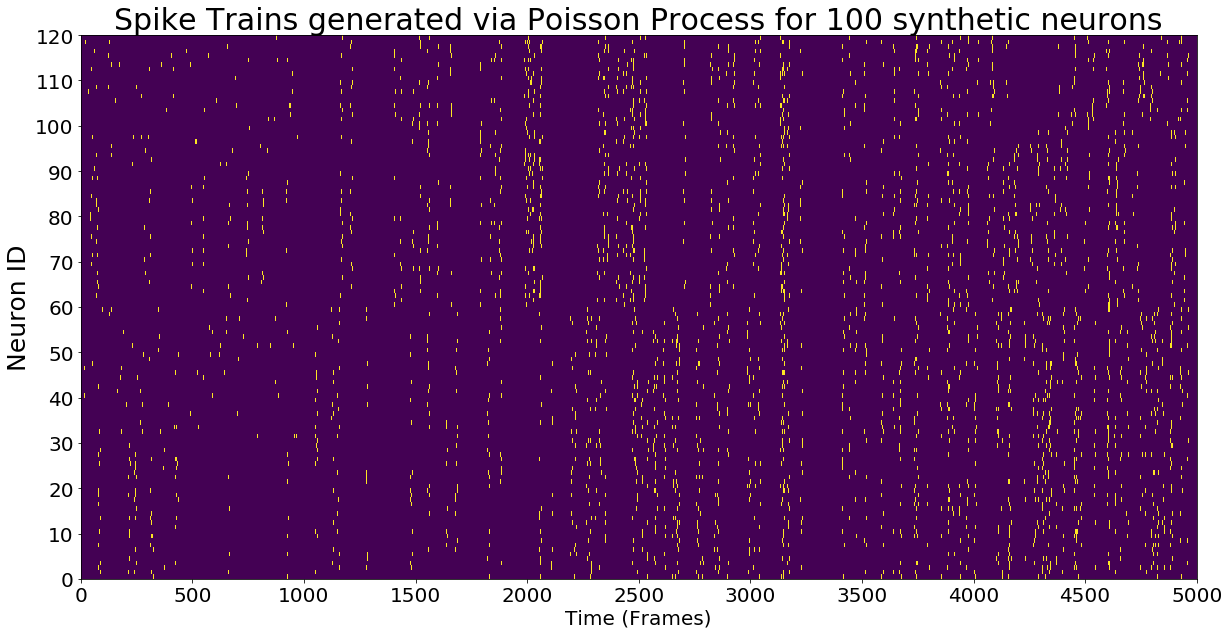

In [6]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.imshow(spikes, origin = 'lower', interpolation='nearest', aspect='auto',  extent = [0,5000,0,120])
ax.set_title('Spike Trains generated via Poisson Process for 100 synthetic neurons', fontsize= 30)
ax.set_xlabel('TIME (in Miliseconds)', fontsize = 20)
ax.set_xticks([j*500 for j in range(11)])
ax.set_yticks([i*10 for i in range(13)])
ax.set_ylabel('Neuron ID', fontsize = 25)
ax.set_xlabel('Time (Frames)', fontsize = 20)
ax.tick_params(axis = 'both', labelsize = 20)
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/spiketrain_synthetic_1.pdf')

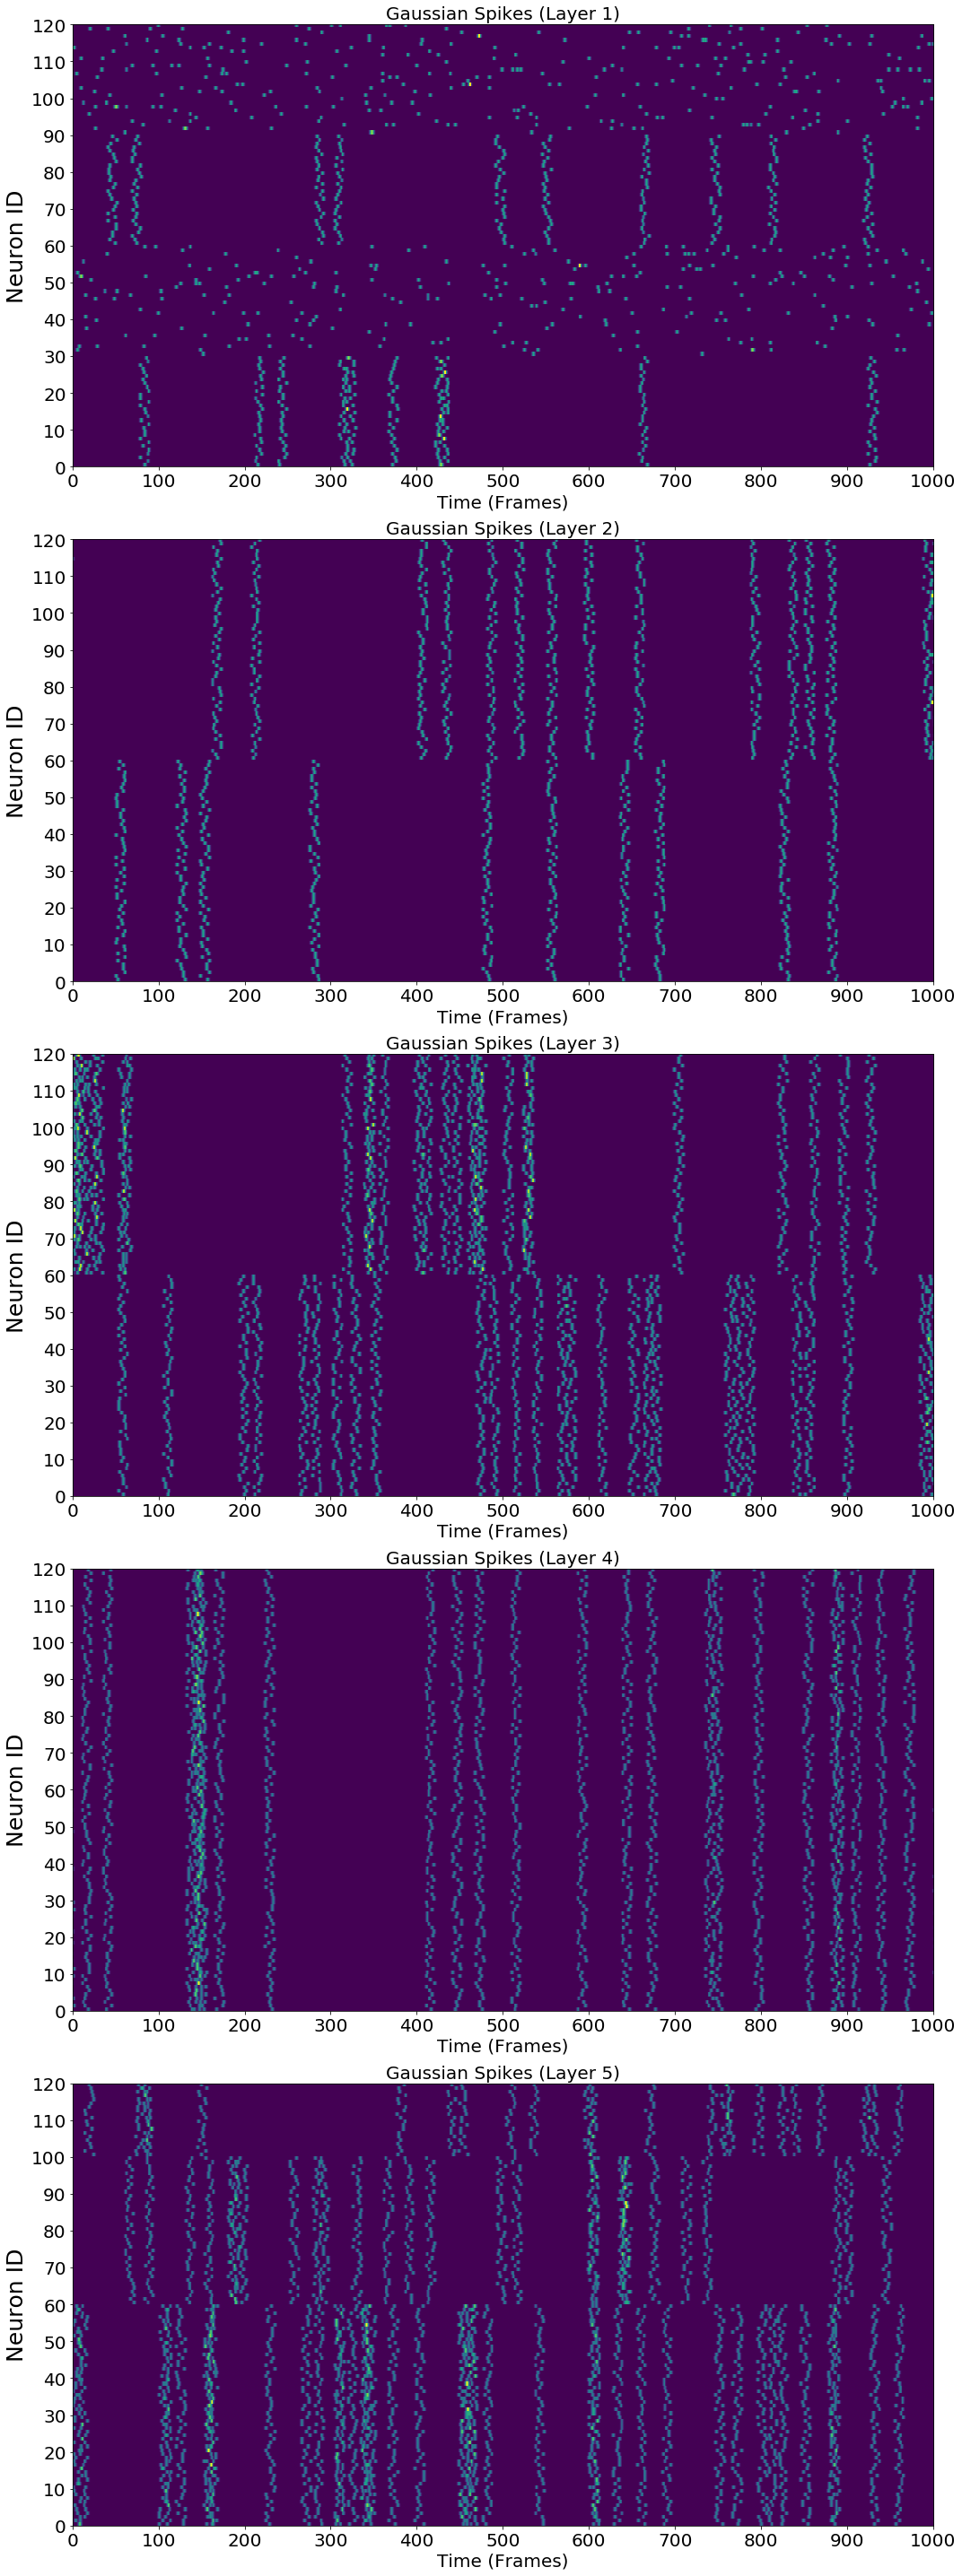

In [7]:
binned_spikes = bin_time_series(spikes, binsize, gaussian = True, sigma = standard_dev)
fig,ax = plt.subplots(layers,1,figsize=(15,40))
for i in range(layers):
    ax[i].imshow(binned_spikes[i], origin = 'lower', interpolation='nearest', aspect='auto', extent = [0,1000,0,120])
    ax[i].set_title('Gaussian Spikes (Layer %d)'%(i+1), fontsize = 20)
    ax[i].set_xlabel('TIME (in Miliseconds)', fontsize = 20)
    ax[i].set_xticks([j*100 for j in range(11)])
    ax[i].set_yticks([j*10 for j in range(13)])
    ax[i].set_ylabel('Neuron ID', fontsize = 25)
    ax[i].set_xlabel('Time (Frames)', fontsize = 20)
    ax[i].tick_params(axis = 'both', labelsize = 20)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/binned_spiketrain_synthetic_1.pdf')

In [8]:
t = int(time*seconds/binsize) ## number of layers
n = 120
##create cross-correlation matrices that are the adjacency matrices of the network at each layer
adjacency_matrices = []
for i in range(t):
    adjacency_matrices.append(cross_correlation_matrix(binned_spikes[i])[0])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


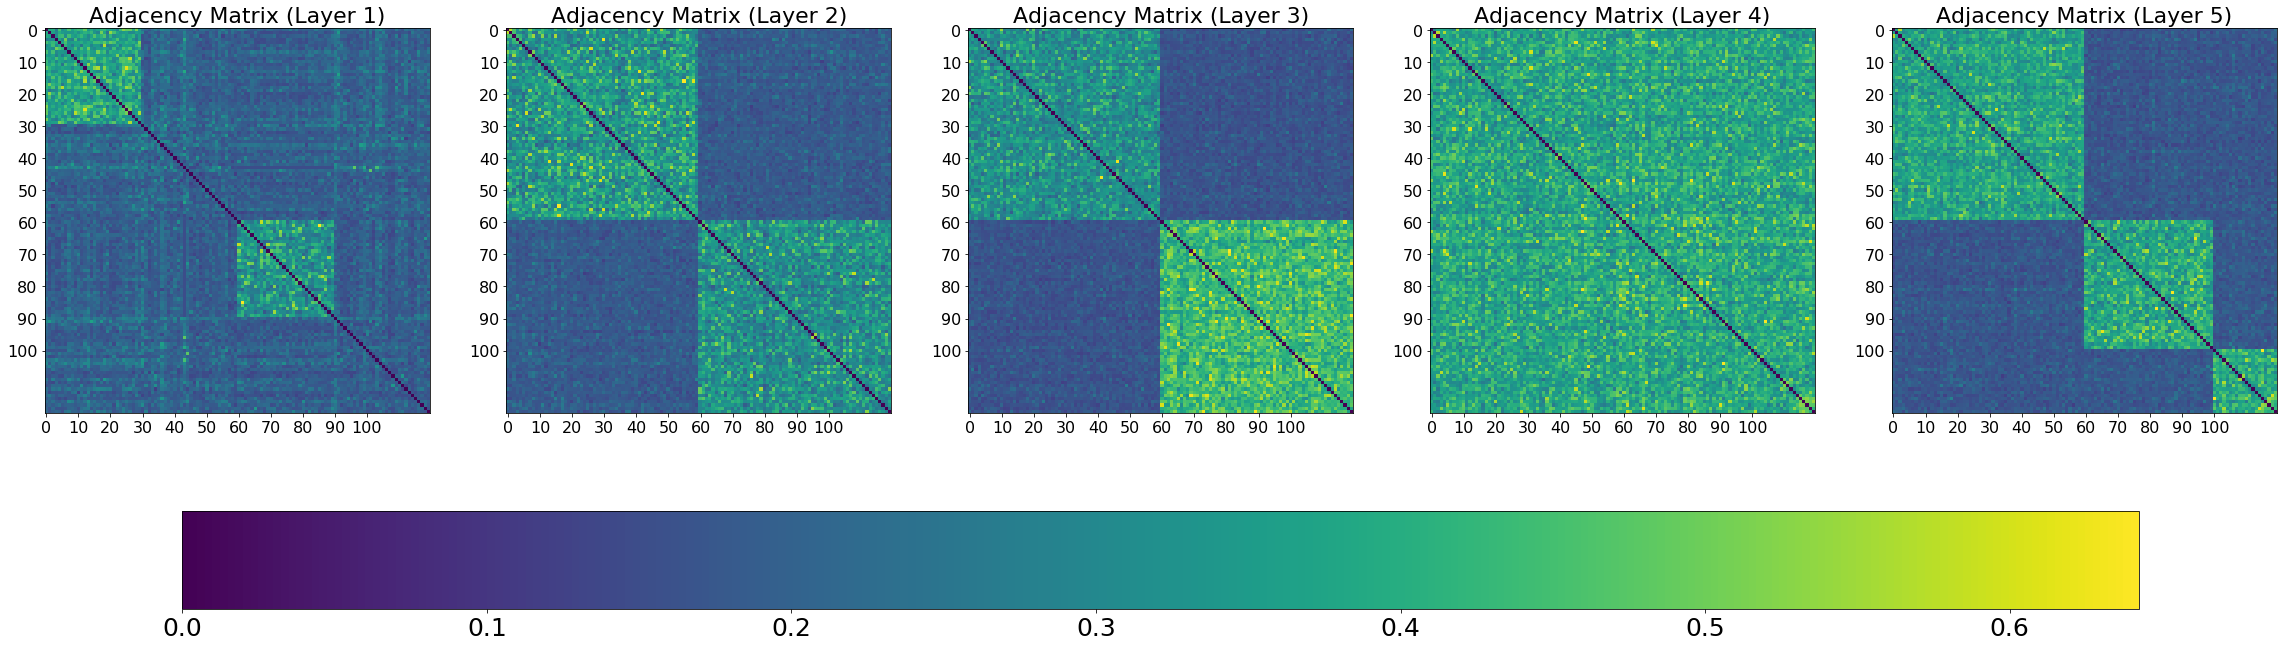

In [11]:
fig,ax = plt.subplots(1, layers, figsize = (40,12))
for i in range(layers):
    k = ax[i].imshow(adjacency_matrices[i])
    ax[i].set_title('Adjacency Matrix (Layer %d)'%(i +1),fontsize=22)
    ax[i].set_xticks([j*10 for j in range(11)])
    ax[i].set_yticks([j*10 for j in range(11)])
    ax[i].tick_params(axis = 'both', labelsize = 16)
cbar = fig.colorbar(k, ax = ax.flat, orientation = 'horizontal')
cbar.ax.tick_params(labelsize = 25) 
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/adjacency_1.pdf')

In [12]:
TN = temporal_network(n, t, data = 'list__adjacency', list_adjacency = adjacency_matrices, omega = 1, kind= 'ordinal')

In [13]:
grid = 50
resolutions = np.linspace(0, 2, grid)
interlayers = np.linspace(0, 2, grid)

In [14]:
community_sizes = {}
membership_partitions = {}
partitions = {}
parameter_plane = np.zeros((len(resolutions),len(interlayers)))
for i,e in enumerate(interlayers):
    comm_size = []
    membership = []
    partition = []
    igraphs = TN.create_igraph()
    for j,f in enumerate(resolutions):
        parts, inter_parts = TN.leiden(igraphs,e,f)
        c_size_layers, c_size  = TN.membership(inter_parts)
        comm_size.append(c_size)
        membership.append(c_size_layers)
        partition.append(inter_parts)
        parameter_plane[i][j] = c_size
    community_sizes['interlayer %.2f'%e] = comm_size
    membership_partitions['interlayer %.2f'%e] = membership
    partitions['interlayer %.2f'%e] = partition

In [ ]:
print('cmm1')
rasters = {}
fig,ax = plt.subplots(10,10, figsize = (10*10+5,10*10))
for i in range(10):
    for j in range(10):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i]][j], ax[i][j])
        ax[i][j].set_xticks([i for i in range(1,layers+1)])
        ax[i][j].set_yticks([i*10 for i in range(11)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i],resolutions[j]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities1_1.pdf')

In [ ]:
print('cmm2')
fig,ax = plt.subplots(10,10, figsize = (10*10+5,10*10))
for i in range(10):
    for j in range(10):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+10]][j], ax[i][j])
        ax[i][j].set_xticks([i for i in range(1,layers+1)])
        ax[i][j].set_yticks([i*10 for i in range(11)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+10],resolutions[j]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities2_1.pdf')

In [ ]:
print('cmm3')
fig,ax = plt.subplots(10,10, figsize = (10*10+5,10*10))
for i in range(10):
    for j in range(10):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+20]][j], ax[i][j])
        ax[i][j].set_xticks([i for i in range(1,layers+1)])
        ax[i][j].set_yticks([i*10 for i in range(11)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+20],resolutions[j]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities3_1.pdf')

In [ ]:
print('cmm4')
fig,ax = plt.subplots(10,10, figsize = (10*10+5,10*10))
for i in range(10):
    for j in range(10):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+30]][j], ax[i][j])
        ax[i][j].set_xticks([i for i in range(1,layers+1)])
        ax[i][j].set_yticks([i*10 for i in range(11)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+30],resolutions[j]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities4_1.pdf')

In [ ]:
print('cmm5')
fig,ax = plt.subplots(10,10, figsize = (10*10+5,10*10))
for i in range(10):
    for j in range(10):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+40]][j], ax[i][j])
        ax[i][j].set_xticks([i for i in range(1,layers+1)])
        ax[i][j].set_yticks([i*10 for i in range(11)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+40],resolutions[j]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities5_1.pdf')

In [ ]:
print('cmm6')
fig,ax = plt.subplots(10,10, figsize = (10*10+5,10*10))
for i in range(10):
    for j in range(10):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i]][j+10], ax[i][j])
        ax[i][j].set_xticks([i for i in range(1,layers+1)])
        ax[i][j].set_yticks([i*10 for i in range(11)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i],resolutions[j+10]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities6_1.pdf')

In [ ]:
print('cmm7')
fig,ax = plt.subplots(10,10, figsize = (10*10+5,10*10))
for i in range(10):
    for j in range(10):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+10]][j+10], ax[i][j])
        ax[i][j].set_xticks([i for i in range(1,layers+1)])
        ax[i][j].set_yticks([i*10 for i in range(11)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+10],resolutions[j+10]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities7_1.pdf')

In [ ]:
print('cmm8')
fig,ax = plt.subplots(10,10, figsize = (10*10+5,10*10))
for i in range(10):
    for j in range(10):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+20]][j+10], ax[i][j])
        ax[i][j].set_xticks([i for i in range(1,layers+1)])
        ax[i][j].set_yticks([i*10 for i in range(11)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+20],resolutions[j+10]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities8_1.pdf')

In [ ]:
print('cmm9')
fig,ax = plt.subplots(10,10, figsize = (10*10+5,10*10))
for i in range(10):
    for j in range(10):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+30]][j+10], ax[i][j])
        ax[i][j].set_xticks([i for i in range(1,layers+1)])
        ax[i][j].set_yticks([i*10 for i in range(11)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+30],resolutions[j+10]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities9_1.pdf')

In [ ]:
print('cmm10')
fig,ax = plt.subplots(10,10, figsize = (10*10+5,10*10))
for i in range(10):
    for j in range(10):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+40]][j+10], ax[i][j])
        ax[i][j].set_xticks([i for i in range(1,layers+1)])
        ax[i][j].set_yticks([i*10 for i in range(11)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+40],resolutions[j+10]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities10_1.pdf')

In [ ]:
print('cmm11')
fig,ax = plt.subplots(10,10, figsize = (10*10+5,10*10))
for i in range(10):
    for j in range(10):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i]][j+20], ax[i][j])
        ax[i][j].set_xticks([i for i in range(1,layers+1)])
        ax[i][j].set_yticks([i*10 for i in range(11)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i],resolutions[j+20]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities11_1.pdf')

In [ ]:
print('cmm12')
fig,ax = plt.subplots(10,10, figsize = (10*10+5,10*10))
for i in range(10):
    for j in range(10):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+10]][j+20], ax[i][j])
        ax[i][j].set_xticks([i for i in range(1,layers+1)])
        ax[i][j].set_yticks([i*10 for i in range(11)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+10],resolutions[j+20]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities12_1.pdf')

In [ ]:
print('cmm13')
fig,ax = plt.subplots(10,10, figsize = (10*10+5,10*10))
for i in range(10):
    for j in range(10):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+20]][j+20], ax[i][j])
        ax[i][j].set_xticks([i for i in range(1,layers+1)])
        ax[i][j].set_yticks([i*10 for i in range(11)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+20],resolutions[j+20]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities13_1.pdf')

In [ ]:
print('cmm14')
fig,ax = plt.subplots(10,10, figsize = (10*10+5,10*10))
for i in range(10):
    for j in range(10):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+30]][j+20], ax[i][j])
        ax[i][j].set_xticks([i for i in range(1,layers+1)])
        ax[i][j].set_yticks([i*10 for i in range(11)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+30],resolutions[j+20]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities14_1.pdf')

In [ ]:
print('cmm15')
fig,ax = plt.subplots(10,10, figsize = (10*10+5,10*10))
for i in range(10):
    for j in range(10):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+40]][j+20], ax[i][j])
        ax[i][j].set_xticks([i for i in range(1,layers+1)])
        ax[i][j].set_yticks([i*10 for i in range(11)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+40],resolutions[j+20]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities15_1.pdf')

In [ ]:
print('cmm16')
fig,ax = plt.subplots(10,10, figsize = (10*10+5,10*10))
for i in range(10):
    for j in range(10):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i]][j+30], ax[i][j])
        ax[i][j].set_xticks([i for i in range(1,layers+1)])
        ax[i][j].set_yticks([i*10 for i in range(11)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i],resolutions[j+30]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities16_1.pdf')

In [ ]:
print('cmm17')
fig,ax = plt.subplots(10,10, figsize = (10*10+5,10*10))
for i in range(10):
    for j in range(10):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+10]][j+30], ax[i][j])
        ax[i][j].set_xticks([i for i in range(1,layers+1)])
        ax[i][j].set_yticks([i*10 for i in range(11)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+10],resolutions[j+30]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities17_1.pdf')

In [ ]:
print('cmm18')
fig,ax = plt.subplots(10,10, figsize = (10*10+5,10*10))
for i in range(10):
    for j in range(10):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+20]][j+30], ax[i][j])
        ax[i][j].set_xticks([i for i in range(1,layers+1)])
        ax[i][j].set_yticks([i*10 for i in range(11)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+20],resolutions[j+30]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities18_1.pdf')

In [ ]:
print('cmm19')
fig,ax = plt.subplots(10,10, figsize = (10*10+5,10*10))
for i in range(10):
    for j in range(10):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+30]][j+30], ax[i][j])
        ax[i][j].set_xticks([i for i in range(1,layers+1)])
        ax[i][j].set_yticks([i*10 for i in range(11)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+30],resolutions[j+30]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities19_1.pdf')

In [ ]:
print('cmm20')
fig,ax = plt.subplots(10,10, figsize = (10*10+5,10*10))
for i in range(10):
    for j in range(10):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+40]][j+30], ax[i][j])
        ax[i][j].set_xticks([i for i in range(1,layers+1)])
        ax[i][j].set_yticks([i*10 for i in range(11)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+40],resolutions[j+30]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities20_1.pdf')

In [ ]:
print('cmm21')
fig,ax = plt.subplots(10,10, figsize = (10*10+5,10*10))
for i in range(10):
    for j in range(10):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i]][j+40], ax[i][j])
        ax[i][j].set_xticks([i for i in range(1,layers+1)])
        ax[i][j].set_yticks([i*10 for i in range(11)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i],resolutions[j+40]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities21_1.pdf')

In [ ]:
print('cmm22')
fig,ax = plt.subplots(10,10, figsize = (10*10+5,10*10))
for i in range(10):
    for j in range(10):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+10]][j+40], ax[i][j])
        ax[i][j].set_xticks([i for i in range(1,layers+1)])
        ax[i][j].set_yticks([i*10 for i in range(11)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+10],resolutions[j+40]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities22_1.pdf')

In [ ]:
print('cmm23')
fig,ax = plt.subplots(10,10, figsize = (10*10+5,10*10))
for i in range(10):
    for j in range(10):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+20]][j+40], ax[i][j])
        ax[i][j].set_xticks([i for i in range(1,layers+1)])
        ax[i][j].set_yticks([i*10 for i in range(11)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+20],resolutions[j+40]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities23_1.pdf')

In [ ]:
print('cmm24')
fig,ax = plt.subplots(10,10, figsize = (10*10+5,10*10))
for i in range(10):
    for j in range(10):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+30]][j+40], ax[i][j])
        ax[i][j].set_xticks([i for i in range(1,layers+1)])
        ax[i][j].set_yticks([i*10 for i in range(11)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+30],resolutions[j+40]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities24_1.pdf')

In [ ]:
print('cmm25')
fig,ax = plt.subplots(10,10, figsize = (10*10+5,10*10))
for i in range(10):
    for j in range(10):
        comms, c = TN.community(membership_partitions['interlayer %.2f'%interlayers[i+40]][j+40], ax[i][j])
        ax[i][j].set_xticks([i for i in range(1,layers+1)])
        ax[i][j].set_yticks([i*10 for i in range(11)])
        ax[i][j].tick_params(axis = 'both', labelsize = 25)
        ax[i][j].set_xlabel('Layers (Time)', fontsize = 28)
        ax[i][j].set_ylabel('Neuron ID', fontsize = 28)
        ax[i][j].set_title('%d Communities, interlayer: %.2f, reso:%.2f'%(len(c),interlayers[i+40],resolutions[j+40]), fontsize=29)
plt.tight_layout()
plt.savefig('/projects/academic/smuldoon/bengieru/leiden/results/communities25_1.pdf')

In [ ]:
np.savetxt('/projects/academic/smuldoon/bengieru/leiden/results/parameter_plane_1.txt', parameter_plane, fmt='%f')